In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist import Rays_GoldenSpiral
from stardist.models import Config3D, StarDist3D, StarDistData3D

np.random.seed(42)
lbl_cmap = random_label_cmap()

Using TensorFlow backend.
/home/prakash/anaconda3/envs/StarDistNewVersion/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/prakash/anaconda3/envs/StarDistNewVersion/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/prakash/anaconda3/envs/StarDistNewVersion/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint1

# Data

We assume that data has already been downloaded via notebook [1_data.ipynb](1_data.ipynb).  

<div class="alert alert-block alert-info">
Training data (for input `X` with associated label masks `Y`) can be provided via lists of numpy arrays, where each image can have a different size. Alternatively, a single numpy array can also be used if all images have the same size.  
Input images can either be three-dimensional (single-channel) or four-dimensional (multi-channel) arrays, where the channel axis comes last. Label images need to be integer-valued.
</div>

In [2]:
src = "/home/prakash/Desktop/Helene/StarDist3D/model2"
X = sorted(glob(f"{src}/raw/*.tif"))
Y = sorted(glob(f"{src}/GT/*.tif"))
for x,y in zip(X,Y):
    print(Path(x).name)
    print(Path(y).name)
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

fish1-48hpf-1202.tif
fish1-48hpf-1202.tif
fish1corrected0502.tif
fish1corrected0502.tif


In [3]:
X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 3 else X[0].shape[-1]

Normalize images and fill small label holes.

In [4]:
axis_norm = (0,1,2)   # normalize channels independently
# axis_norm = (0,1,2,3) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 3 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Split into train and validation datasets.

In [5]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:   2
- training:         1
- validation:       1


Training data consists of pairs of input image and label instances.

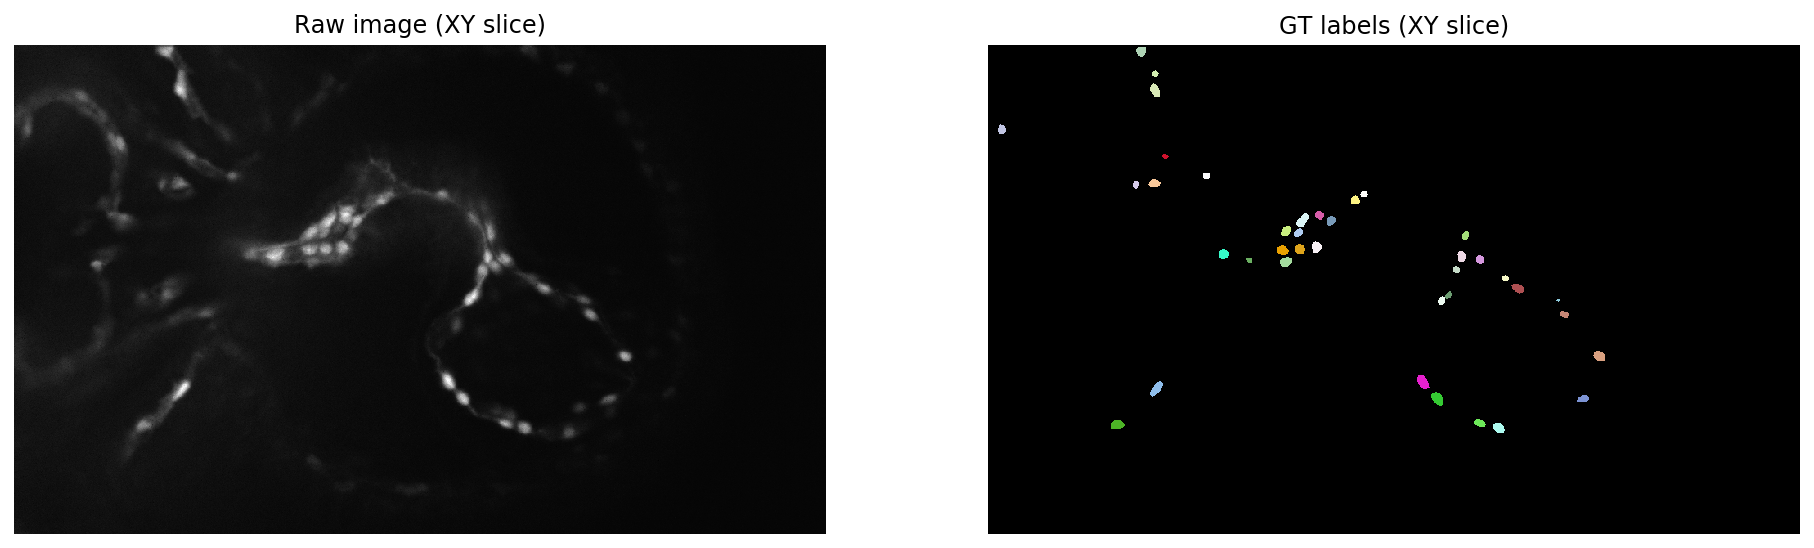

In [6]:
i = 0
img, lbl = X[i], Y[i]
assert img.ndim in (3,4)
img = img if img.ndim==3 else img[...,:3]
z = img.shape[0] // 2
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img[z],cmap='gray');   plt.axis('off'); plt.title('Raw image (XY slice)')
plt.subplot(122); plt.imshow(lbl[z],cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels (XY slice)')
None;

# Configuration

A `StarDist3D` model is specified via a `Config3D` object.

In [7]:
print(Config3D.__doc__)

Configuration for a :class:`StarDist3D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    rays : Rays_Base, int, or None
        Ray factory (e.g. Ray_GoldenSpiral). 
        If an integer then Ray_GoldenSpiral(rays) will be used
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    anisotropy : (float,float,float)
        Anisotropy of objects along each of the axes.
        Use ``None`` to disable only for (nearly) isotropic objects shapes.
        Also see ``utils.calculate_extents``.
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : in

In [8]:
extents = calculate_extents(Y)
anisotropy = tuple(np.max(extents) / extents)
print('empirical anisotropy of labeled objects = %s' % str(anisotropy))

empirical anisotropy of labeled objects = (1.0, 1.5714285714285714, 1.6296296296296295)


In [9]:
# 96 is a good default choice (see 1_data.ipynb)
n_rays = 96

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = tuple(1 if a > 1.5 else 2 for a in anisotropy)

# Use rays on a Fibonacci lattice adjusted for measured anisotropy of the training data
rays = Rays_GoldenSpiral(n_rays, anisotropy=anisotropy)

conf = Config3D (
    rays             = rays,
    grid             = grid,
    anisotropy       = anisotropy,
    use_gpu          = use_gpu,
    n_channel_in     = n_channel,
    # adjust for your data below (make patch size as large as possible)
    train_patch_size = (48,96,96),
    train_batch_size = 2,
)
print(conf)
vars(conf)

Config3D(anisotropy=(1.0, 1.5714285714285714, 1.6296296296296295), axes='ZYXC', backbone='resnet', grid=(2, 1, 1), n_channel_in=1, n_channel_out=97, n_dim=3, n_rays=96, net_conv_after_resnet=128, net_input_shape=(None, None, None, 1), net_mask_shape=(None, None, None, 1), rays_json={'name': 'Rays_GoldenSpiral', 'kwargs': {'n': 96, 'anisotropy': (1.0, 1.5714285714285714, 1.6296296296296295)}}, resnet_activation='relu', resnet_batch_norm=False, resnet_kernel_init='he_normal', resnet_kernel_size=(3, 3, 3), resnet_n_blocks=4, resnet_n_conv_per_block=3, resnet_n_filter_base=32, train_background_reg=0.0001, train_batch_size=2, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_dist_loss='mae', train_epochs=400, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(48, 96, 96), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_steps_per_epoch=100, train_

{'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 97,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 96,
 'grid': (2, 1, 1),
 'anisotropy': (1.0, 1.5714285714285714, 1.6296296296296295),
 'backbone': 'resnet',
 'rays_json': {'name': 'Rays_GoldenSpiral',
  'kwargs': {'n': 96,
   'anisotropy': (1.0, 1.5714285714285714, 1.6296296296296295)}},
 'resnet_n_blocks': 4,
 'resnet_kernel_size': (3, 3, 3),
 'resnet_kernel_init': 'he_normal',
 'resnet_n_filter_base': 32,
 'resnet_n_conv_per_block': 3,
 'resnet_activation': 'relu',
 'resnet_batch_norm': False,
 'net_conv_after_resnet': 128,
 'net_input_shape': (None, None, None, 1),
 'net_mask_shape': (None, None, None, 1),
 'train_patch_size': (48, 96, 96),
 'train_background_reg': 0.0001,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,
 'tra

In [10]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)

**Note:** The trained `StarDist3D` model will *not* predict completed shapes for partially visible objects at the image boundary.

In [11]:
model = StarDist3D(conf, name='stardist_fish_2gt_model2', basedir='models')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


Check if the neural network has a large enough field of view to see up to the boundary of most objects.

In [12]:
median_size = calculate_extents(Y, np.median)
fov = np.array(model._axes_tile_overlap('ZYX'))
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

# Training

You can define a function/callable that applies augmentation to each batch of the data generator.

In [13]:
augmenter = None

# def augmenter(X_batch, Y_batch):
#     """Augmentation for data batch.
#     X_batch is a list of input images (length at most batch_size)
#     Y_batch is the corresponding list of ground-truth label images
#     """
#     # ...
#     return X_batch, Y_batch

We recommend to monitor the progress during training with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard). You can start it in the shell from the current working directory like this:

    $ tensorboard --logdir=.

Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.


In [14]:
quick_demo = False

if quick_demo:
    print (
        "NOTE: This is only for a quick demonstration!\n"
        "      Please set the variable 'quick_demo = False' for proper (long) training.",
        file=sys.stderr, flush=True
    )
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
                epochs=2, steps_per_epoch=5)

    print("====> Stopping training and loading previously trained demo model from disk.", file=sys.stderr, flush=True)
    model = StarDist3D(None, name='3D_demo', basedir='../../models/examples')
    model.basedir = None # to prevent files of the demo model to be overwritten (not needed for your model)
else:
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter)
None;

Epoch 1/400
100/100 [==============================] - 78s 776ms/step - loss: 0.9492 - prob_loss: 0.1506 - dist_loss: 3.9933 - prob_kld: 0.1398 - dist_relevant_mae: 3.9931 - dist_relevant_mse: 34.7020 - val_loss: 0.6008 - val_prob_loss: 0.0336 - val_dist_loss: 2.8360 - val_prob_kld: 0.0302 - val_dist_relevant_mae: 2.8354 - val_dist_relevant_mse: 16.1008
Epoch 2/400
100/100 [==============================] - 79s 785ms/step - loss: 0.7001 - prob_loss: 0.1048 - dist_loss: 2.9765 - prob_kld: 0.0945 - dist_relevant_mae: 2.9761 - dist_relevant_mse: 17.6088 - val_loss: 0.7890 - val_prob_loss: 0.0235 - val_dist_loss: 3.8276 - val_prob_kld: 0.0200 - val_dist_relevant_mae: 3.8267 - val_dist_relevant_mse: 24.6512
Epoch 3/400
100/100 [==============================] - 79s 788ms/step - loss: 0.6431 - prob_loss: 0.0997 - dist_loss: 2.7168 - prob_kld: 0.0894 - dist_relevant_mae: 2.7163 - dist_relevant_mse: 15.3745 - val_loss: 0.7456 - val_prob_loss: 0.0130 - val_dist_loss: 3.6634 - val_prob_kld: 0.00

100/100 [==============================] - 79s 789ms/step - loss: 0.4030 - prob_loss: 0.0238 - dist_loss: 1.8963 - prob_kld: 0.0101 - dist_relevant_mae: 1.8957 - dist_relevant_mse: 7.9678 - val_loss: 0.4002 - val_prob_loss: 0.0064 - val_dist_loss: 1.9692 - val_prob_kld: 0.0030 - val_dist_relevant_mae: 1.9688 - val_dist_relevant_mse: 7.4716
Epoch 25/400
100/100 [==============================] - 79s 786ms/step - loss: 0.3960 - prob_loss: 0.0233 - dist_loss: 1.8636 - prob_kld: 0.0116 - dist_relevant_mae: 1.8631 - dist_relevant_mse: 7.7597 - val_loss: 0.3536 - val_prob_loss: 0.0053 - val_dist_loss: 1.7419 - val_prob_kld: 0.0018 - val_dist_relevant_mae: 1.7414 - val_dist_relevant_mse: 6.1765
Epoch 26/400
100/100 [==============================] - 79s 790ms/step - loss: 0.3807 - prob_loss: 0.0186 - dist_loss: 1.8104 - prob_kld: 0.0082 - dist_relevant_mae: 1.8100 - dist_relevant_mse: 7.5800 - val_loss: 0.3231 - val_prob_loss: 0.0052 - val_dist_loss: 1.5897 - val_prob_kld: 0.0018 - val_dist_r

100/100 [==============================] - 76s 759ms/step - loss: 0.3421 - prob_loss: 0.0162 - dist_loss: 1.6297 - prob_kld: 0.0058 - dist_relevant_mae: 1.6294 - dist_relevant_mse: 6.0991 - val_loss: 0.2897 - val_prob_loss: 0.0056 - val_dist_loss: 1.4204 - val_prob_kld: 0.0022 - val_dist_relevant_mae: 1.4201 - val_dist_relevant_mse: 4.2994
Epoch 48/400
100/100 [==============================] - 78s 779ms/step - loss: 0.3593 - prob_loss: 0.0210 - dist_loss: 1.6916 - prob_kld: 0.0085 - dist_relevant_mae: 1.6913 - dist_relevant_mse: 6.5622 - val_loss: 0.3252 - val_prob_loss: 0.0058 - val_dist_loss: 1.5972 - val_prob_kld: 0.0024 - val_dist_relevant_mae: 1.5969 - val_dist_relevant_mse: 4.9750
Epoch 49/400
100/100 [==============================] - 77s 771ms/step - loss: 0.3425 - prob_loss: 0.0212 - dist_loss: 1.6065 - prob_kld: 0.0075 - dist_relevant_mae: 1.6062 - dist_relevant_mse: 6.2806 - val_loss: 0.2737 - val_prob_loss: 0.0066 - val_dist_loss: 1.3359 - val_prob_kld: 0.0031 - val_dist_r

100/100 [==============================] - 77s 769ms/step - loss: 0.3277 - prob_loss: 0.0182 - dist_loss: 1.5475 - prob_kld: 0.0060 - dist_relevant_mae: 1.5472 - dist_relevant_mse: 5.6664 - val_loss: 0.2871 - val_prob_loss: 0.0058 - val_dist_loss: 1.4065 - val_prob_kld: 0.0024 - val_dist_relevant_mae: 1.4062 - val_dist_relevant_mse: 4.1148
Epoch 71/400
100/100 [==============================] - 75s 748ms/step - loss: 0.3278 - prob_loss: 0.0154 - dist_loss: 1.5619 - prob_kld: 0.0056 - dist_relevant_mae: 1.5616 - dist_relevant_mse: 5.6466 - val_loss: 0.3297 - val_prob_loss: 0.0048 - val_dist_loss: 1.6247 - val_prob_kld: 0.0014 - val_dist_relevant_mae: 1.6244 - val_dist_relevant_mse: 5.1715
Epoch 72/400
100/100 [==============================] - 77s 774ms/step - loss: 0.3263 - prob_loss: 0.0198 - dist_loss: 1.5327 - prob_kld: 0.0071 - dist_relevant_mae: 1.5323 - dist_relevant_mse: 5.5319 - val_loss: 0.3116 - val_prob_loss: 0.0054 - val_dist_loss: 1.5307 - val_prob_kld: 0.0020 - val_dist_r

100/100 [==============================] - 79s 788ms/step - loss: 0.3122 - prob_loss: 0.0175 - dist_loss: 1.4732 - prob_kld: 0.0057 - dist_relevant_mae: 1.4730 - dist_relevant_mse: 5.4034 - val_loss: 0.2703 - val_prob_loss: 0.0054 - val_dist_loss: 1.3245 - val_prob_kld: 0.0020 - val_dist_relevant_mae: 1.3242 - val_dist_relevant_mse: 3.6760
Epoch 94/400
100/100 [==============================] - 77s 771ms/step - loss: 0.3088 - prob_loss: 0.0157 - dist_loss: 1.4656 - prob_kld: 0.0054 - dist_relevant_mae: 1.4653 - dist_relevant_mse: 5.2101 - val_loss: 0.2432 - val_prob_loss: 0.0052 - val_dist_loss: 1.1901 - val_prob_kld: 0.0018 - val_dist_relevant_mae: 1.1899 - val_dist_relevant_mse: 3.1834
Epoch 95/400
100/100 [==============================] - 77s 771ms/step - loss: 0.3138 - prob_loss: 0.0171 - dist_loss: 1.4832 - prob_kld: 0.0054 - dist_relevant_mae: 1.4830 - dist_relevant_mse: 5.3289 - val_loss: 0.2594 - val_prob_loss: 0.0051 - val_dist_loss: 1.2713 - val_prob_kld: 0.0017 - val_dist_r

100/100 [==============================] - 76s 757ms/step - loss: 0.3218 - prob_loss: 0.0170 - dist_loss: 1.5240 - prob_kld: 0.0053 - dist_relevant_mae: 1.5238 - dist_relevant_mse: 5.5599 - val_loss: 0.2711 - val_prob_loss: 0.0059 - val_dist_loss: 1.3257 - val_prob_kld: 0.0025 - val_dist_relevant_mae: 1.3255 - val_dist_relevant_mse: 3.7987
Epoch 117/400
100/100 [==============================] - 77s 772ms/step - loss: 0.2748 - prob_loss: 0.0146 - dist_loss: 1.3009 - prob_kld: 0.0048 - dist_relevant_mae: 1.3007 - dist_relevant_mse: 4.0695 - val_loss: 0.2474 - val_prob_loss: 0.0053 - val_dist_loss: 1.2101 - val_prob_kld: 0.0019 - val_dist_relevant_mae: 1.2099 - val_dist_relevant_mse: 3.2742
Epoch 118/400
100/100 [==============================] - 79s 790ms/step - loss: 0.2846 - prob_loss: 0.0152 - dist_loss: 1.3469 - prob_kld: 0.0055 - dist_relevant_mae: 1.3467 - dist_relevant_mse: 4.4535 - val_loss: 0.2409 - val_prob_loss: 0.0048 - val_dist_loss: 1.1806 - val_prob_kld: 0.0014 - val_dist

100/100 [==============================] - 77s 774ms/step - loss: 0.2752 - prob_loss: 0.0148 - dist_loss: 1.3021 - prob_kld: 0.0043 - dist_relevant_mae: 1.3019 - dist_relevant_mse: 4.1528 - val_loss: 0.2821 - val_prob_loss: 0.0058 - val_dist_loss: 1.3815 - val_prob_kld: 0.0024 - val_dist_relevant_mae: 1.3815 - val_dist_relevant_mse: 4.0429
Epoch 140/400
100/100 [==============================] - 76s 760ms/step - loss: 0.2970 - prob_loss: 0.0205 - dist_loss: 1.3828 - prob_kld: 0.0071 - dist_relevant_mae: 1.3826 - dist_relevant_mse: 4.7137 - val_loss: 0.2444 - val_prob_loss: 0.0047 - val_dist_loss: 1.1983 - val_prob_kld: 0.0013 - val_dist_relevant_mae: 1.1982 - val_dist_relevant_mse: 3.0812
Epoch 141/400
100/100 [==============================] - 78s 784ms/step - loss: 0.2876 - prob_loss: 0.0184 - dist_loss: 1.3459 - prob_kld: 0.0059 - dist_relevant_mae: 1.3458 - dist_relevant_mse: 4.3996 - val_loss: 0.2257 - val_prob_loss: 0.0052 - val_dist_loss: 1.1025 - val_prob_kld: 0.0018 - val_dist

Epoch 162/400
100/100 [==============================] - 75s 754ms/step - loss: 0.2421 - prob_loss: 0.0160 - dist_loss: 1.1302 - prob_kld: 0.0040 - dist_relevant_mae: 1.1301 - dist_relevant_mse: 3.2718 - val_loss: 0.2175 - val_prob_loss: 0.0048 - val_dist_loss: 1.0634 - val_prob_kld: 0.0014 - val_dist_relevant_mae: 1.0633 - val_dist_relevant_mse: 2.5327
Epoch 163/400
100/100 [==============================] - 76s 759ms/step - loss: 0.2284 - prob_loss: 0.0129 - dist_loss: 1.0773 - prob_kld: 0.0030 - dist_relevant_mae: 1.0771 - dist_relevant_mse: 3.1130 - val_loss: 0.2398 - val_prob_loss: 0.0054 - val_dist_loss: 1.1719 - val_prob_kld: 0.0020 - val_dist_relevant_mae: 1.1717 - val_dist_relevant_mse: 3.1062
Epoch 164/400
100/100 [==============================] - 78s 778ms/step - loss: 0.2338 - prob_loss: 0.0147 - dist_loss: 1.0957 - prob_kld: 0.0036 - dist_relevant_mae: 1.0955 - dist_relevant_mse: 3.0448 - val_loss: 0.2329 - val_prob_loss: 0.0051 - val_dist_loss: 1.1386 - val_prob_kld: 0.0

100/100 [==============================] - 77s 774ms/step - loss: 0.2402 - prob_loss: 0.0160 - dist_loss: 1.1206 - prob_kld: 0.0039 - dist_relevant_mae: 1.1205 - dist_relevant_mse: 3.2518 - val_loss: 0.2158 - val_prob_loss: 0.0050 - val_dist_loss: 1.0537 - val_prob_kld: 0.0016 - val_dist_relevant_mae: 1.0536 - val_dist_relevant_mse: 2.6519
Epoch 186/400
100/100 [==============================] - 80s 797ms/step - loss: 0.2238 - prob_loss: 0.0152 - dist_loss: 1.0429 - prob_kld: 0.0033 - dist_relevant_mae: 1.0429 - dist_relevant_mse: 2.9400 - val_loss: 0.2506 - val_prob_loss: 0.0057 - val_dist_loss: 1.2244 - val_prob_kld: 0.0023 - val_dist_relevant_mae: 1.2244 - val_dist_relevant_mse: 3.3091
Epoch 187/400
100/100 [==============================] - 77s 771ms/step - loss: 0.2258 - prob_loss: 0.0155 - dist_loss: 1.0514 - prob_kld: 0.0033 - dist_relevant_mae: 1.0513 - dist_relevant_mse: 2.8759 - val_loss: 0.2385 - val_prob_loss: 0.0052 - val_dist_loss: 1.1668 - val_prob_kld: 0.0018 - val_dist

100/100 [==============================] - 77s 770ms/step - loss: 0.2237 - prob_loss: 0.0147 - dist_loss: 1.0450 - prob_kld: 0.0032 - dist_relevant_mae: 1.0449 - dist_relevant_mse: 2.7480 - val_loss: 0.2062 - val_prob_loss: 0.0052 - val_dist_loss: 1.0049 - val_prob_kld: 0.0018 - val_dist_relevant_mae: 1.0048 - val_dist_relevant_mse: 2.3309
Epoch 209/400
100/100 [==============================] - 82s 821ms/step - loss: 0.2074 - prob_loss: 0.0129 - dist_loss: 0.9724 - prob_kld: 0.0029 - dist_relevant_mae: 0.9724 - dist_relevant_mse: 2.4235 - val_loss: 0.2152 - val_prob_loss: 0.0057 - val_dist_loss: 1.0476 - val_prob_kld: 0.0023 - val_dist_relevant_mae: 1.0476 - val_dist_relevant_mse: 2.5973
Epoch 210/400
100/100 [==============================] - 75s 747ms/step - loss: 0.2164 - prob_loss: 0.0166 - dist_loss: 0.9990 - prob_kld: 0.0036 - dist_relevant_mae: 0.9989 - dist_relevant_mse: 2.6266 - val_loss: 0.2267 - val_prob_loss: 0.0059 - val_dist_loss: 1.1038 - val_prob_kld: 0.0025 - val_dist

100/100 [==============================] - 79s 786ms/step - loss: 0.2134 - prob_loss: 0.0162 - dist_loss: 0.9858 - prob_kld: 0.0032 - dist_relevant_mae: 0.9857 - dist_relevant_mse: 2.5857 - val_loss: 0.2307 - val_prob_loss: 0.0054 - val_dist_loss: 1.1265 - val_prob_kld: 0.0020 - val_dist_relevant_mae: 1.1264 - val_dist_relevant_mse: 2.9010
Epoch 232/400
100/100 [==============================] - 74s 735ms/step - loss: 0.2038 - prob_loss: 0.0134 - dist_loss: 0.9522 - prob_kld: 0.0027 - dist_relevant_mae: 0.9521 - dist_relevant_mse: 2.3862 - val_loss: 0.2123 - val_prob_loss: 0.0049 - val_dist_loss: 1.0369 - val_prob_kld: 0.0015 - val_dist_relevant_mae: 1.0368 - val_dist_relevant_mse: 2.5208
Epoch 233/400
100/100 [==============================] - 78s 783ms/step - loss: 0.2158 - prob_loss: 0.0175 - dist_loss: 0.9915 - prob_kld: 0.0033 - dist_relevant_mae: 0.9914 - dist_relevant_mse: 2.5595 - val_loss: 0.2227 - val_prob_loss: 0.0053 - val_dist_loss: 1.0868 - val_prob_kld: 0.0019 - val_dist

Epoch 254/400
100/100 [==============================] - 75s 749ms/step - loss: 0.2010 - prob_loss: 0.0151 - dist_loss: 0.9295 - prob_kld: 0.0028 - dist_relevant_mae: 0.9294 - dist_relevant_mse: 2.2803 - val_loss: 0.2275 - val_prob_loss: 0.0057 - val_dist_loss: 1.1092 - val_prob_kld: 0.0023 - val_dist_relevant_mae: 1.1091 - val_dist_relevant_mse: 2.9753
Epoch 255/400
100/100 [==============================] - 79s 790ms/step - loss: 0.1985 - prob_loss: 0.0137 - dist_loss: 0.9241 - prob_kld: 0.0025 - dist_relevant_mae: 0.9241 - dist_relevant_mse: 2.3304 - val_loss: 0.2383 - val_prob_loss: 0.0058 - val_dist_loss: 1.1622 - val_prob_kld: 0.0024 - val_dist_relevant_mae: 1.1622 - val_dist_relevant_mse: 3.1811
Epoch 256/400
100/100 [==============================] - 74s 739ms/step - loss: 0.1955 - prob_loss: 0.0154 - dist_loss: 0.9004 - prob_kld: 0.0028 - dist_relevant_mae: 0.9003 - dist_relevant_mse: 2.1453 - val_loss: 0.2267 - val_prob_loss: 0.0055 - val_dist_loss: 1.1062 - val_prob_kld: 0.0

100/100 [==============================] - 77s 775ms/step - loss: 0.1908 - prob_loss: 0.0142 - dist_loss: 0.8827 - prob_kld: 0.0026 - dist_relevant_mae: 0.8826 - dist_relevant_mse: 2.1010 - val_loss: 0.2537 - val_prob_loss: 0.0060 - val_dist_loss: 1.2385 - val_prob_kld: 0.0026 - val_dist_relevant_mae: 1.2384 - val_dist_relevant_mse: 3.5184
Epoch 278/400
100/100 [==============================] - 76s 758ms/step - loss: 0.1800 - prob_loss: 0.0130 - dist_loss: 0.8351 - prob_kld: 0.0025 - dist_relevant_mae: 0.8350 - dist_relevant_mse: 1.8598 - val_loss: 0.2565 - val_prob_loss: 0.0062 - val_dist_loss: 1.2513 - val_prob_kld: 0.0028 - val_dist_relevant_mae: 1.2513 - val_dist_relevant_mse: 3.5651
Epoch 279/400
100/100 [==============================] - 76s 761ms/step - loss: 0.1958 - prob_loss: 0.0132 - dist_loss: 0.9130 - prob_kld: 0.0022 - dist_relevant_mae: 0.9129 - dist_relevant_mse: 2.2245 - val_loss: 0.2411 - val_prob_loss: 0.0055 - val_dist_loss: 1.1777 - val_prob_kld: 0.0021 - val_dist

Epoch 300/400
100/100 [==============================] - 76s 764ms/step - loss: 0.1802 - prob_loss: 0.0113 - dist_loss: 0.8446 - prob_kld: 0.0019 - dist_relevant_mae: 0.8446 - dist_relevant_mse: 2.0242 - val_loss: 0.2264 - val_prob_loss: 0.0057 - val_dist_loss: 1.1036 - val_prob_kld: 0.0023 - val_dist_relevant_mae: 1.1036 - val_dist_relevant_mse: 3.0485
Epoch 301/400
100/100 [==============================] - 93s 929ms/step - loss: 0.1880 - prob_loss: 0.0144 - dist_loss: 0.8684 - prob_kld: 0.0025 - dist_relevant_mae: 0.8683 - dist_relevant_mse: 2.0824 - val_loss: 0.2395 - val_prob_loss: 0.0061 - val_dist_loss: 1.1670 - val_prob_kld: 0.0027 - val_dist_relevant_mae: 1.1670 - val_dist_relevant_mse: 3.4674
Epoch 302/400
100/100 [==============================] - 80s 797ms/step - loss: 0.1830 - prob_loss: 0.0158 - dist_loss: 0.8356 - prob_kld: 0.0029 - dist_relevant_mae: 0.8355 - dist_relevant_mse: 1.8658 - val_loss: 0.2311 - val_prob_loss: 0.0060 - val_dist_loss: 1.1255 - val_prob_kld: 0.0

100/100 [==============================] - 77s 774ms/step - loss: 0.1809 - prob_loss: 0.0150 - dist_loss: 0.8295 - prob_kld: 0.0024 - dist_relevant_mae: 0.8295 - dist_relevant_mse: 1.8780 - val_loss: 0.2444 - val_prob_loss: 0.0057 - val_dist_loss: 1.1932 - val_prob_kld: 0.0023 - val_dist_relevant_mae: 1.1932 - val_dist_relevant_mse: 3.4689
Epoch 324/400
100/100 [==============================] - 76s 763ms/step - loss: 0.1797 - prob_loss: 0.0122 - dist_loss: 0.8376 - prob_kld: 0.0021 - dist_relevant_mae: 0.8375 - dist_relevant_mse: 1.9665 - val_loss: 0.2365 - val_prob_loss: 0.0061 - val_dist_loss: 1.1522 - val_prob_kld: 0.0027 - val_dist_relevant_mae: 1.1521 - val_dist_relevant_mse: 3.3468
Epoch 325/400
100/100 [==============================] - 79s 792ms/step - loss: 0.1894 - prob_loss: 0.0161 - dist_loss: 0.8664 - prob_kld: 0.0026 - dist_relevant_mae: 0.8663 - dist_relevant_mse: 2.0389 - val_loss: 0.2397 - val_prob_loss: 0.0059 - val_dist_loss: 1.1690 - val_prob_kld: 0.0025 - val_dist

Epoch 346/400
100/100 [==============================] - 78s 784ms/step - loss: 0.1688 - prob_loss: 0.0141 - dist_loss: 0.7735 - prob_kld: 0.0021 - dist_relevant_mae: 0.7734 - dist_relevant_mse: 1.7243 - val_loss: 0.2472 - val_prob_loss: 0.0061 - val_dist_loss: 1.2053 - val_prob_kld: 0.0027 - val_dist_relevant_mae: 1.2053 - val_dist_relevant_mse: 3.5901
Epoch 347/400
100/100 [==============================] - 78s 777ms/step - loss: 0.1830 - prob_loss: 0.0151 - dist_loss: 0.8393 - prob_kld: 0.0024 - dist_relevant_mae: 0.8392 - dist_relevant_mse: 1.9762 - val_loss: 0.2538 - val_prob_loss: 0.0063 - val_dist_loss: 1.2374 - val_prob_kld: 0.0029 - val_dist_relevant_mae: 1.2374 - val_dist_relevant_mse: 3.7582
Epoch 348/400
100/100 [==============================] - 77s 772ms/step - loss: 0.1777 - prob_loss: 0.0123 - dist_loss: 0.8270 - prob_kld: 0.0020 - dist_relevant_mae: 0.8270 - dist_relevant_mse: 1.8867 - val_loss: 0.2467 - val_prob_loss: 0.0062 - val_dist_loss: 1.2025 - val_prob_kld: 0.0

100/100 [==============================] - 81s 806ms/step - loss: 0.1830 - prob_loss: 0.0153 - dist_loss: 0.8386 - prob_kld: 0.0023 - dist_relevant_mae: 0.8385 - dist_relevant_mse: 1.9830 - val_loss: 0.2446 - val_prob_loss: 0.0062 - val_dist_loss: 1.1919 - val_prob_kld: 0.0028 - val_dist_relevant_mae: 1.1918 - val_dist_relevant_mse: 3.5753
Epoch 370/400
100/100 [==============================] - 79s 793ms/step - loss: 0.1662 - prob_loss: 0.0105 - dist_loss: 0.7787 - prob_kld: 0.0015 - dist_relevant_mae: 0.7786 - dist_relevant_mse: 1.6755 - val_loss: 0.2413 - val_prob_loss: 0.0061 - val_dist_loss: 1.1763 - val_prob_kld: 0.0027 - val_dist_relevant_mae: 1.1763 - val_dist_relevant_mse: 3.5068
Epoch 371/400
100/100 [==============================] - 79s 787ms/step - loss: 0.1825 - prob_loss: 0.0156 - dist_loss: 0.8343 - prob_kld: 0.0023 - dist_relevant_mae: 0.8342 - dist_relevant_mse: 1.9025 - val_loss: 0.2452 - val_prob_loss: 0.0061 - val_dist_loss: 1.1951 - val_prob_kld: 0.0027 - val_dist

100/100 [==============================] - 75s 747ms/step - loss: 0.1703 - prob_loss: 0.0141 - dist_loss: 0.7813 - prob_kld: 0.0021 - dist_relevant_mae: 0.7812 - dist_relevant_mse: 1.6956 - val_loss: 0.2457 - val_prob_loss: 0.0061 - val_dist_loss: 1.1976 - val_prob_kld: 0.0027 - val_dist_relevant_mae: 1.1976 - val_dist_relevant_mse: 3.5399
Epoch 393/400
100/100 [==============================] - 77s 768ms/step - loss: 0.1701 - prob_loss: 0.0128 - dist_loss: 0.7864 - prob_kld: 0.0020 - dist_relevant_mae: 0.7864 - dist_relevant_mse: 1.7768 - val_loss: 0.2462 - val_prob_loss: 0.0061 - val_dist_loss: 1.2006 - val_prob_kld: 0.0027 - val_dist_relevant_mae: 1.2006 - val_dist_relevant_mse: 3.4866
Epoch 394/400
100/100 [==============================] - 78s 777ms/step - loss: 0.1640 - prob_loss: 0.0123 - dist_loss: 0.7588 - prob_kld: 0.0019 - dist_relevant_mae: 0.7588 - dist_relevant_mse: 1.6023 - val_loss: 0.2434 - val_prob_loss: 0.0060 - val_dist_loss: 1.1872 - val_prob_kld: 0.0026 - val_dist

# Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [15]:
model.optimize_thresholds(X_val, Y_val)

ResourceExhaustedError: OOM when allocating tensor with shape[1,242,598,993,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv3d_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_input_0_0/_669, conv3d_1/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
